In [1]:
import pandas as pd
import numpy as np

# Load the data from the CSV file
file_path = 'Otherdata/bank-additional-full.csv'
data = pd.read_csv(file_path, delimiter=';')  # Assuming delimiter is semicolon based on common format

# Display basic information and the first few rows of the dataset
# data_info = data.info()
# data_head = data.head()
# data_info, data_head

data


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [2]:
data['cons.price.idx'].unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431, 92.649,
       92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199,
       94.601, 94.767])

In [3]:

# Determine the maximum age to define the upper limit of the bins
max_age = data['age'].max()

# Create bins from the minimum age up to the maximum, in 5-year increments
bins = np.arange(0, max_age + 5, 5)  # Plus 5 to ensure the maximum age is included in the range

# Define labels for each bin
labels = [f'{i} - {i + 4}' for i in bins[:-1]]

# Bin the ages and create a new column
data['Age_Bin'] = pd.cut(data['age'], bins=bins, labels=labels, right=True, include_lowest=True)

# Display the updated DataFrame to confirm the new 'Age_Bin' column
print(data[['age', 'Age_Bin']].head())


   age  Age_Bin
0   56  55 - 59
1   57  55 - 59
2   37  35 - 39
3   40  35 - 39
4   56  55 - 59


In [4]:
data_no = data[data['y'] == 'no']
data_yes = data[data['y'] == 'yes']
data_yes

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,Age_Bin
75,41,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,40 - 44
83,49,entrepreneur,married,university.degree,unknown,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,45 - 49
88,49,technician,married,basic.9y,no,no,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,45 - 49
129,41,technician,married,professional.course,unknown,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,40 - 44
139,45,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes,40 - 44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,...,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes,60 - 64
41178,62,retired,married,university.degree,no,no,no,cellular,nov,thu,...,6,3,success,-1.1,94.767,-50.8,1.031,4963.6,yes,60 - 64
41181,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,35 - 39
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,70 - 74


In [5]:
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [6]:
# data = remove_outliers(data, 'age')


# **Yes_Split**

## **Opitimal K**

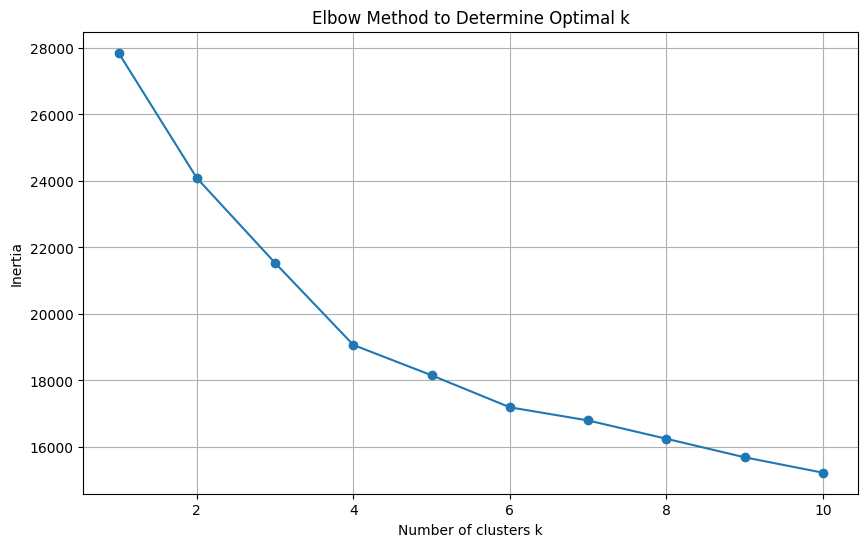

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting the columns
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']

# Subset the data with selected features
data_subset = data_yes[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), ['job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Check the transformed data shape and type to confirm
data_processed.shape, type(data_processed)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Setting a range for possible k values
k_values = range(1, 11)
inertias = []

# Calculate the inertia for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_processed)
    inertias.append(model.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()



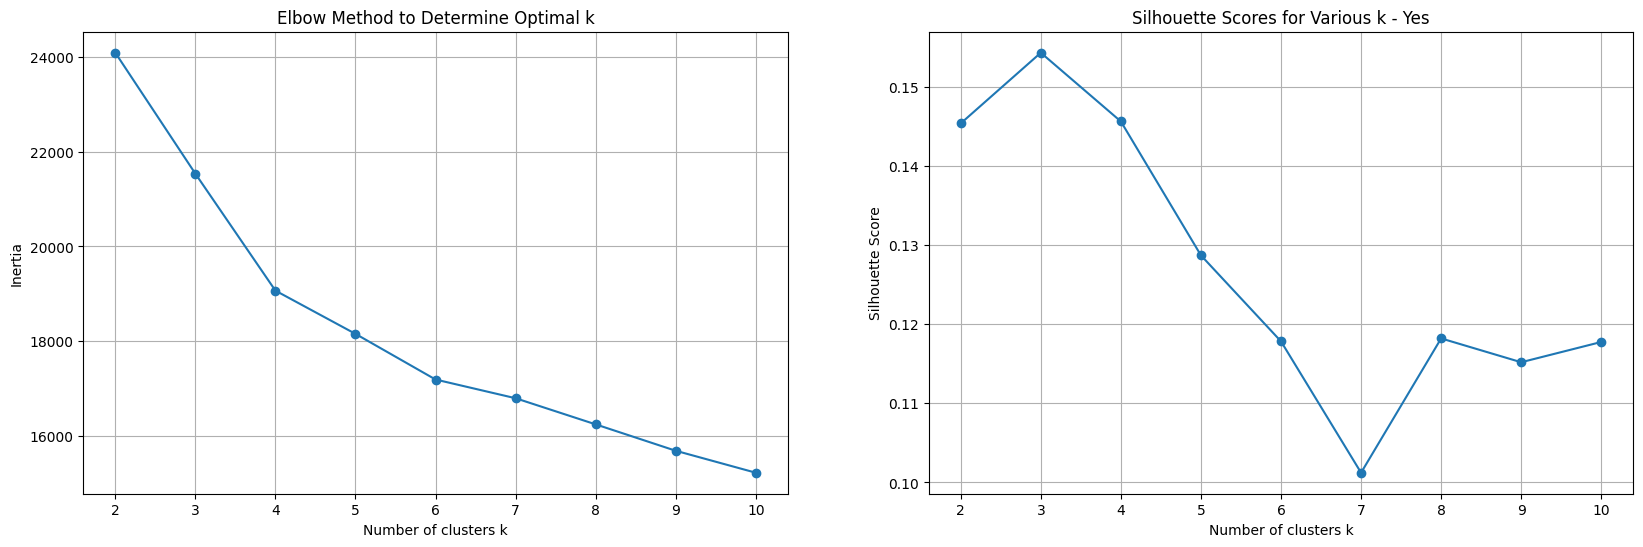

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'data_processed' is the preprocessed data from your dataset

# Setting a range for possible k values
k_values = range(2, 11)  # Starting from 2 because silhouette score is not defined for k=1
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette score for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(data_processed)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_processed, cluster_labels))

# Create a figure with a specified size
plt.figure(figsize=(20, 6))  # Increase width to accommodate two subplots

# Plotting the elbow graph for Inertia
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)

# Plotting the silhouette scores
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k - Yes')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Show the plot
plt.show()


## **Cluster Characteristics**

In [9]:
# Subset the data with selected features and preprocess
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']
data_subset = data_yes[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age','cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), [ 'job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Assuming k=3 from previous optimal k analysis or a typical starting point for exploration
k = 4
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(data_processed)

# Adding cluster labels to the original DataFrame for analysis
data_yes['Cluster'] = cluster_labels

# Aggregating data to summarize cluster characteristics
cluster_summary = data_yes.groupby('Cluster').agg({
    'age': ['mean', 'median'],
    'cons.price.idx': ['mean', 'median'],
    'campaign': ['mean', 'median'],
    'job': lambda x: x.value_counts().index[0],  # Most common category
    'education': lambda x: x.value_counts().index[0],
    'marital': lambda x: x.value_counts().index[0],
    'housing': lambda x: x.value_counts().index[0],
    'loan': lambda x: x.value_counts().index[0]
})

cluster_summary




C:\Users\rbrul\AppData\Local\Temp\ipykernel_30584\1879663336.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_yes['Cluster'] = cluster_labels


age        cons.price.idx          campaign             job  \
              mean median           mean  median      mean median <lambda>   
Cluster                                                                      
0        60.896347   58.0      93.133398  93.075  1.720632    1.0  retired   
1        36.948123   36.0      94.083016  93.994  1.809556    2.0   admin.   
2        40.221843   38.0      93.601676  93.918  6.866894    6.0   admin.   
3        33.298555   33.0      92.864264  92.893  1.666132    1.0   admin.   

                 education  marital  housing     loan  
                  <lambda> <lambda> <lambda> <lambda>  
Cluster                                                
0                 basic.4y  married      yes       no  
1        university.degree  married      yes       no  
2        university.degree  married      yes       no  
3        university.degree   single      yes       no

In [10]:
# Convert cluster_labels array to a pandas Series
cluster_series = pd.Series(cluster_labels)

# Count the number of points in each cluster
cluster_counts = cluster_series.value_counts()

# Display the cluster counts
print(cluster_counts)


3    1869
1    1465
0    1013
2     293
Name: count, dtype: int64


# **No_Split**

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting the columns
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']

# Subset the data with selected features
data_subset = data_no[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), ['job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Check the transformed data shape and type to confirm
data_processed.shape, type(data_processed)

((36548, 33), scipy.sparse._csr.csr_matrix)

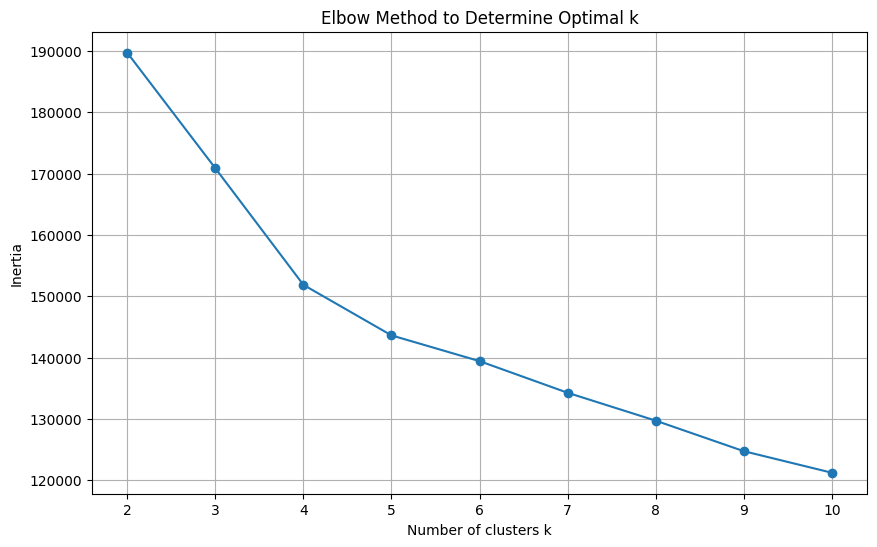

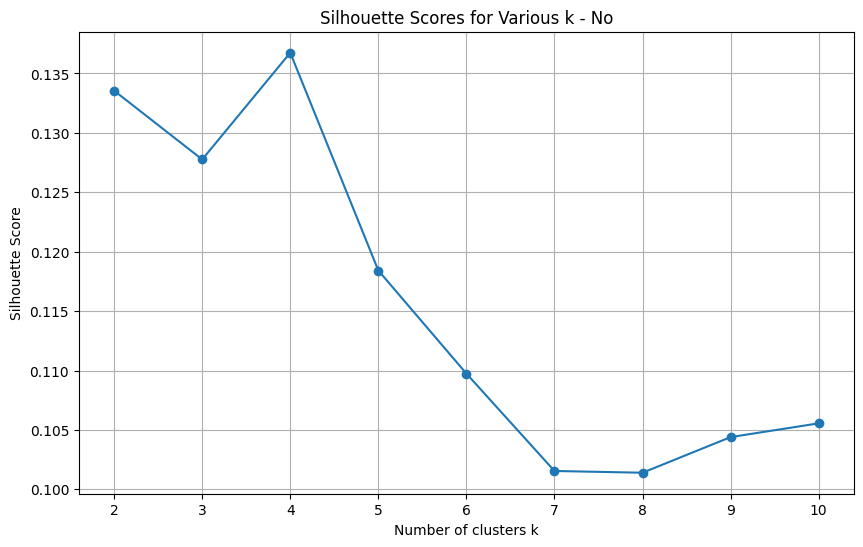

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Setting a range for possible k values
k_values = range(2, 11)  # Starting from 2 because silhouette score is not defined for k=1
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette score for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(data_processed)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_processed, cluster_labels))

# Plotting the elbow graph for Inertia
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k - No')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


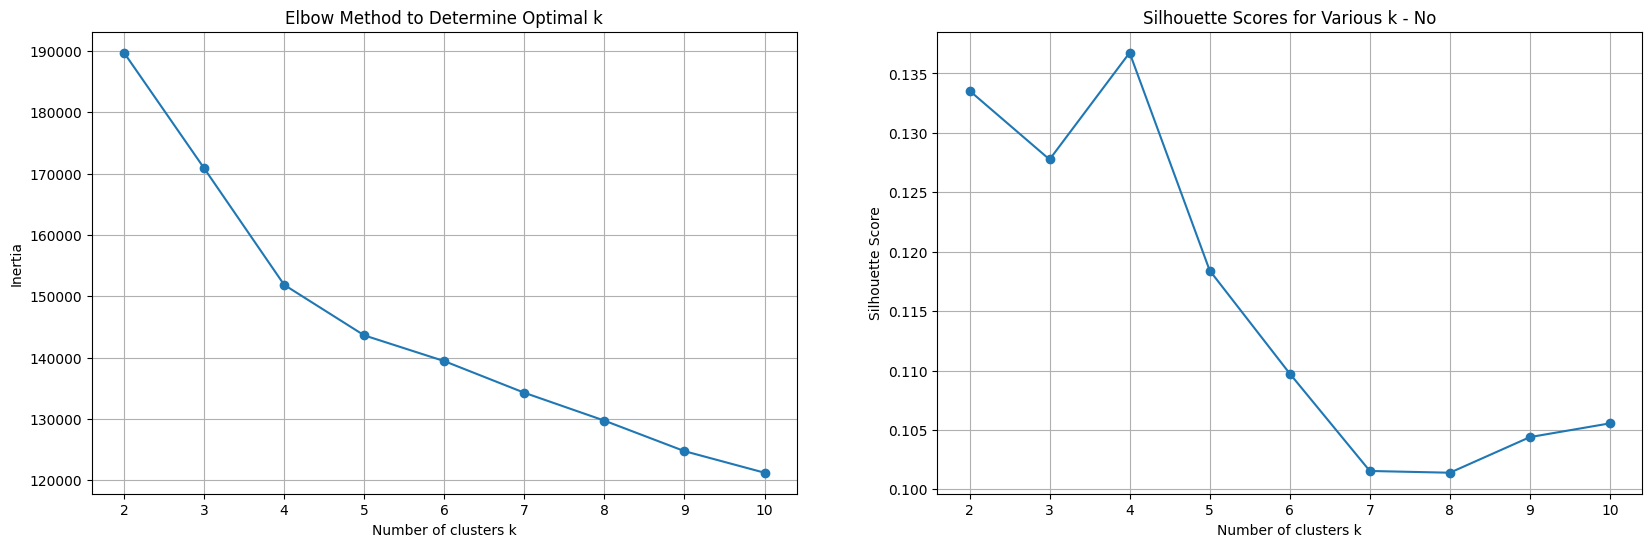

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming 'data_processed' is the preprocessed data from your dataset

# Setting a range for possible k values
k_values = range(2, 11)  # Starting from 2 because silhouette score is not defined for k=1
inertias = []
silhouette_scores = []

# Calculate the inertia and silhouette score for each k
for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(data_processed)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_processed, cluster_labels))

# Create a figure with a specified size
plt.figure(figsize=(20, 6))  # Increase width to accommodate two subplots

# Plotting the elbow graph for Inertia
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.grid(True)

# Plotting the silhouette scores
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Various k - No')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Show the plot
plt.show()


## **Cluster Characteristics**

In [14]:
# Subset the data with selected features and preprocess
features = ['age', 'job', 'education', 'marital', 'housing', 'loan', 'cons.price.idx', 'campaign']
data_subset = data_no[features]

# Define the column transformer: one-hot encode categorical features and scale numerical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'cons.price.idx', 'campaign']),
        ('cat', OneHotEncoder(), ['job', 'education', 'marital', 'housing', 'loan'])
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(data_subset)

# Assuming k=3 from previous optimal k analysis or a typical starting point for exploration
k = 4
model = KMeans(n_clusters=k, random_state=42)
cluster_labels = model.fit_predict(data_processed)

# Adding cluster labels to the original DataFrame for analysis
data_no['Cluster'] = cluster_labels

# Aggregating data to summarize cluster characteristics
cluster_summary = data_no.groupby('Cluster').agg({
    'age': ['mean', 'median'],
    'cons.price.idx': ['mean', 'median'],
    'campaign': ['mean', 'median'],
    'job': lambda x: x.value_counts().index[0],  # Most common category
    'education': lambda x: x.value_counts().index[0],
    'marital': lambda x: x.value_counts().index[0],
    'housing': lambda x: x.value_counts().index[0],
    'loan': lambda x: x.value_counts().index[0]
})

cluster_summary


C:\Users\rbrul\AppData\Local\Temp\ipykernel_30584\1402592833.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no['Cluster'] = cluster_labels


age        cons.price.idx           campaign         \
              mean median           mean  median       mean median   
Cluster                                                              
0        34.801176   35.0      94.092350  93.994   2.261419    2.0   
1        34.822592   34.0      93.056453  93.075   2.111668    2.0   
2        52.406355   52.0      93.621625  93.918   2.204164    2.0   
3        40.346365   39.0      93.903167  93.918  13.246228   11.0   

                 job          education  marital  housing     loan  
            <lambda>           <lambda> <lambda> <lambda> <lambda>  
Cluster                                                             
0        blue-collar        high.school  married       no       no  
1             admin.  university.degree  married      yes       no  
2        blue-collar  university.degree  married      yes       no  
3             admin.  university.degree  married      yes       no

In [15]:
# Convert cluster_labels array to a pandas Series
cluster_series = pd.Series(cluster_labels)

# Count the number of points in each cluster
cluster_counts = cluster_series.value_counts()

# Display the cluster counts
print(cluster_counts)

0    12589
1    12367
2    10134
3     1458
Name: count, dtype: int64
